In [124]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('default')
import scipy.stats as stats
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
from lmfit import Model,Minimizer
import corner
import numdifftools
from scipy.ndimage.interpolation import shift
import pickle
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
arr = pickle.load(open('modelspecs.p','rb'))
modelspectra = arr[0]
teffs = arr[2]
loggs = arr[1]

In [142]:
normspec = [];

lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

for i in tqdm(range(len(modelspectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],modelspectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (modelspectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 1040/1040 [00:02<00:00, 366.24it/s]


1040

In [143]:
sc = StandardScaler()
msc = StandardScaler()

teffmask = teffs <= 1000000

In [157]:
X = sc.fit_transform(np.stack((teffs[teffmask],loggs[teffmask])).transpose())
t = (normspec[teffmask])

In [158]:
def generator():
    x = Input(shape=(2,))
    y = Dense(25,activation='relu')(x)
    y = Dropout(0.5)(y)
    y = Dense(25,activation='relu')(y)
    y = Dropout(0.5)(y)
    out = Dense(3000,activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 25)                75        
_________________________________________________________________
dropout_19 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_20 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 3000)              78000     
Total params: 78,725
Trainable params: 78,725
Non-trainable params: 0
_________________________________________________________________
None


In [230]:
epoch = 25000
batch = len(X)
history = [];
for i in tqdm(range(epoch)):
    h = model.fit(X,t,epochs=1,verbose=0,batch_size=batch)
    history.append(h.history['loss'][0])

100%|██████████| 25000/25000 [13:08<00:00, 32.38it/s]


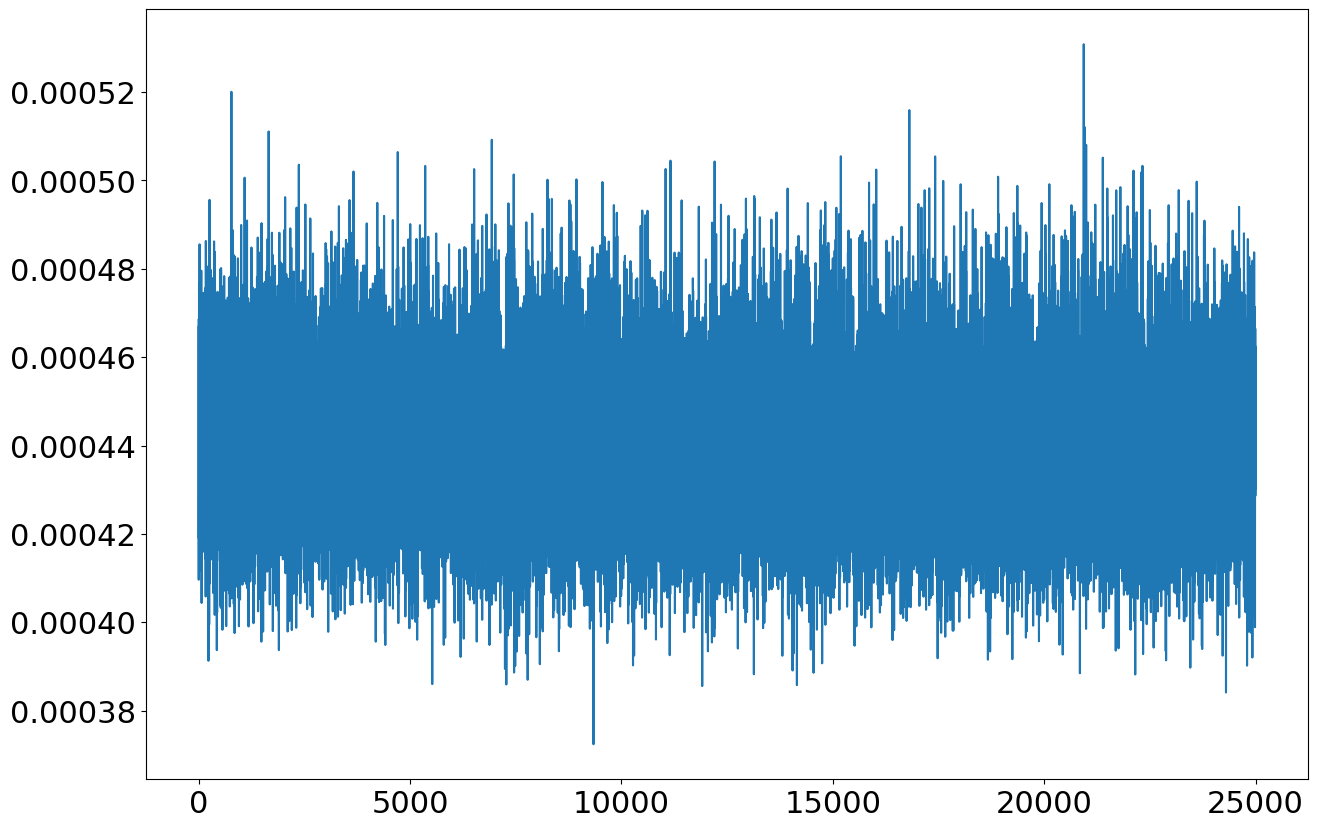

In [231]:
plt.plot(history)

In [232]:
preds = model.predict(X)

In [233]:
i = np.random.randint(0,len(X))
plt.plot(msc.inverse_transform(t[i]))
plt.plot(msc.inverse_transform(preds[i]))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

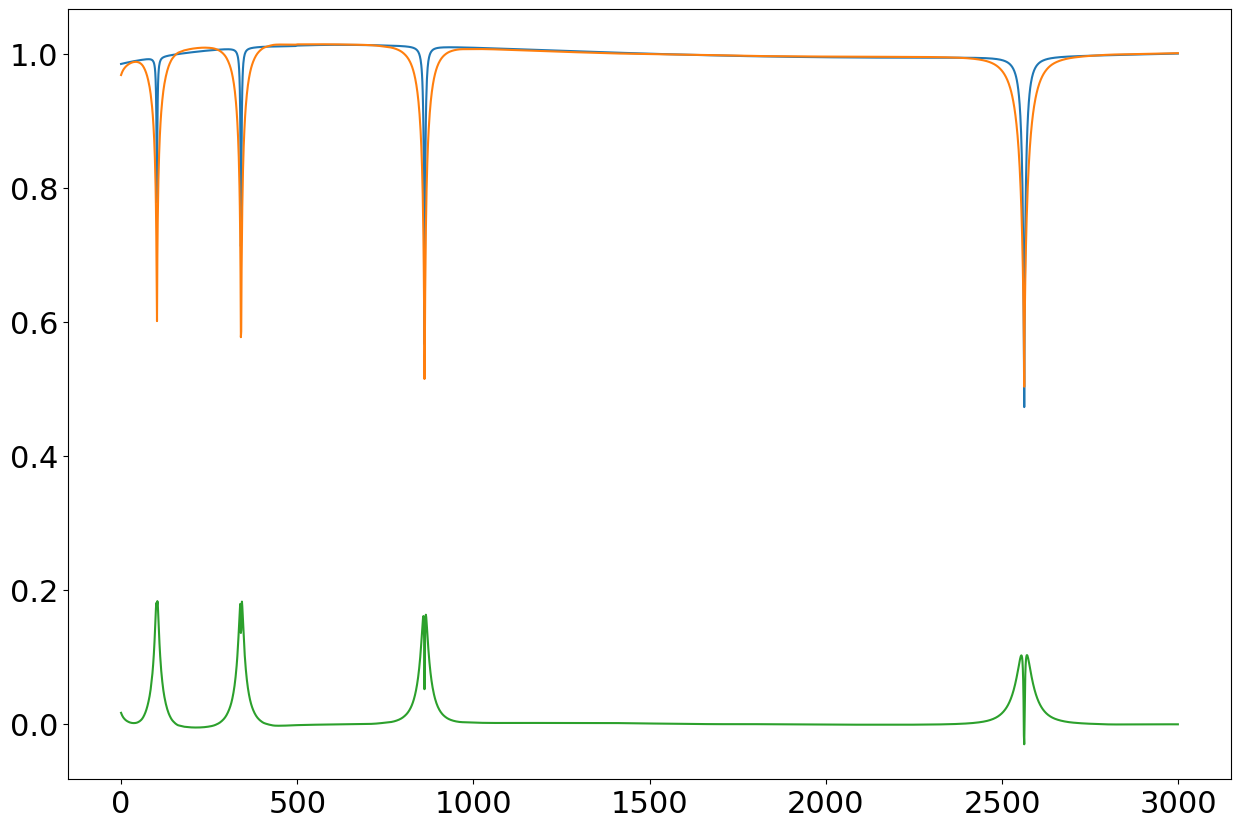

In [244]:
i = np.random.randint(0,len(X))
plt.plot((t[i]))
plt.plot((preds[i]))
plt.plot(t[i]-preds[i])

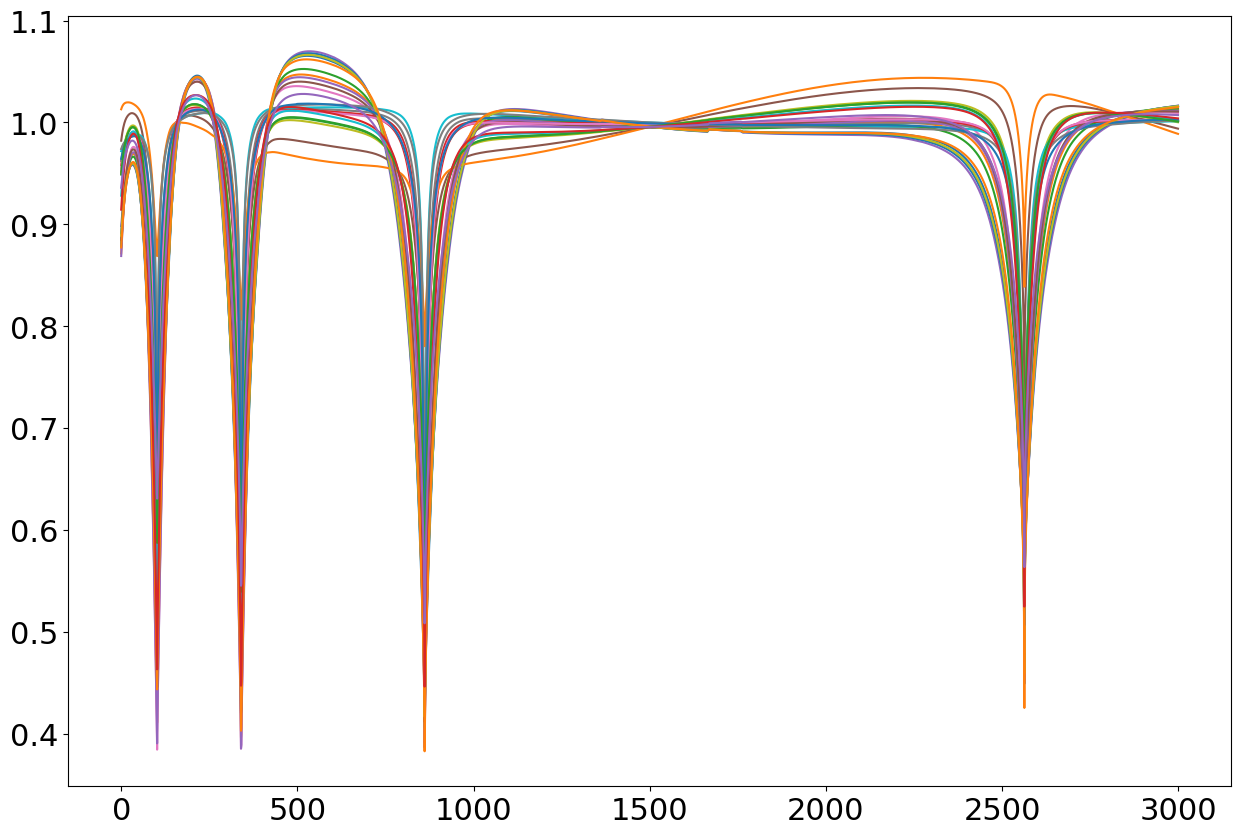

In [229]:
plt.plot(preds[0:25].transpose())

In [173]:
preds.shape

(1040, 3000)